# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [2]:
data = pd.read_csv('data/flightsrandom200000.csv')

In [3]:
p = pd.read_csv('data/passengers.csv')

In [4]:
df2 = p[['departures_performed','seats','passengers','carrier','month']].groupby(['carrier','month']).mean().reset_index()

In [5]:
df = data[['fl_date','mkt_carrier','origin','dest','crs_dep_time','crs_arr_time','crs_elapsed_time','distance','cancelled']]

In [6]:
df.head()

,fl_date,mkt_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,cancelled
0,3/27/2019,DL,RSW,ATL,630,816,106,515,0
1,3/8/2018,AA,GSO,CLT,1745,1847,62,83,0
2,11/14/2018,UA,ORD,DEN,750,928,158,888,0
3,8/2/2018,DL,SLC,TUS,855,944,109,601,0
4,10/14/2018,DL,XNA,ATL,600,843,103,589,0


### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [7]:
df.loc[:,'month'] = df['fl_date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').month)
df.loc[:,'weekday'] = df['fl_date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').weekday())

df.loc[:,'crs_dep_time']=df['crs_dep_time'].replace(2400.0,0)
df.loc[:,'crs_arr_time']=df['crs_arr_time'].replace(2400.0,0)
df.loc[:,'dep_hour'] = df['crs_dep_time'].apply(lambda x: datetime.datetime.strptime(str(int(x)).zfill(4), '%H%M').hour)
df.loc[:,'arr_hour'] = df['crs_arr_time'].apply(lambda x: datetime.datetime.strptime(str(int(x)).zfill(4), '%H%M').hour)

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [8]:
df = df.drop(columns=['fl_date','crs_dep_time','crs_arr_time'])

In [9]:
df = pd.merge(df,df2, how = 'left', left_on=['mkt_carrier','month'], right_on=['carrier','month']).drop(columns='carrier')

In [10]:
df['pas/dep'] = df['passengers']/df['departures_performed']
df['filled'] = df['passengers']/df['seats']
df=df.drop(columns=['departures_performed','seats','passengers'])

In [11]:
air = (df.groupby('origin').count().div(len(df))*100).sort_values('dest',ascending=False).reset_index()
sum = 0
ori = 0
for i, row in air.iterrows():
    sum += row[1]
    if(sum>=96):
        ori = i
        break
air = (df.groupby('dest').count().div(len(df))*100).sort_values('origin',ascending=False).reset_index()
sum = 0
des = 0
for i, row in air.iterrows():
    sum += row[1]
    if(sum>=96):
        des = i
        break


lst = df.groupby('origin').count().sort_values('dest',ascending=False).reset_index().loc[ori:,'origin']
df.loc[df['origin'].isin(lst),'origin'] = 'Other'
lst = df.groupby('dest').count().sort_values('origin',ascending=False).reset_index().loc[des:,'dest']
df.loc[df['dest'].isin(lst),'dest'] = 'Other'

In [12]:
temp = df.groupby('origin').count().sort_values('dest',ascending=False).reset_index().iloc[:,:1]
temp['origin_index'] = temp.index
df = pd.merge(df,temp,how='left',left_on='origin',right_on='origin')

temp = df.groupby('dest').count().sort_values('origin',ascending=False).reset_index().iloc[:,:1]
temp['dest_index'] = temp.index
df = pd.merge(df,temp,how='left',left_on='dest',right_on='dest')
df = df.drop(columns=['origin','dest'])

temp = df.groupby('mkt_carrier').count().sort_values('origin_index',ascending=False).reset_index().iloc[:,:1]
temp['carrier_index'] = temp.index
df = pd.merge(df,temp,how='left',left_on='mkt_carrier',right_on='mkt_carrier')

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['crs_elapsed_time','distance','pas/dep']] = scaler.fit_transform(df[['crs_elapsed_time','distance','pas/dep']])


In [14]:
df = df.dropna()
y = df['cancelled']
df = df.drop(columns=['cancelled','mkt_carrier'])

In [15]:
from imblearn.under_sampling import RandomUnderSampler
rand = RandomUnderSampler(random_state=1)
X_res, y_res = rand.fit_resample(df, y)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size = .2,random_state=0)


### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
# param_grid = {
#     'penalty': ['l2', 'elasticnet', 'none'],
#     'C': [10000,5000,2000,1000,500,250]
# }

# grid = GridSearchCV(estimator = LogisticRegression(solver='sag'), param_grid = param_grid, n_jobs=-1, verbose = 1)
# grid.fit(X_train,y_train)

In [20]:
#grid.best_params_

In [21]:
#clf = LogisticRegression(C=grid.best_params_['C'], penalty = grid.best_params_['penalty'], solver='sag')
clf = LogisticRegression(C=500, penalty = 'l2', solver='sag')

In [22]:
clf.fit(X_train,y_train)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=500, solver='sag')

In [23]:
y_pred = clf.predict(X_test)

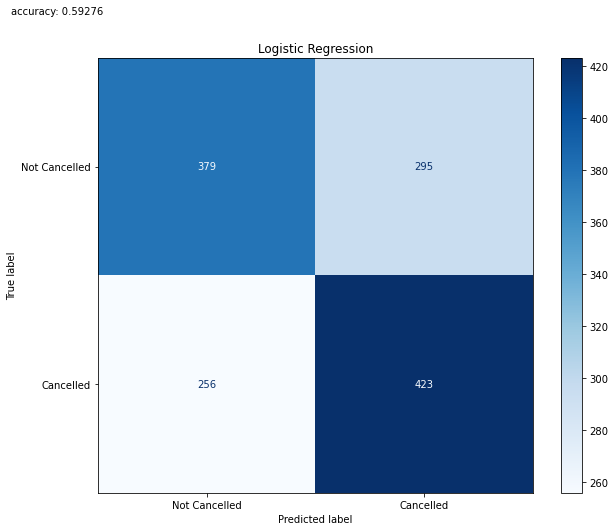

In [24]:
plt.rcParams["figure.figsize"] = (10,8)
disp = plot_confusion_matrix(clf,X_test,y_test,cmap=plt.cm.Blues,display_labels=['Not Cancelled','Cancelled'])
plt.title('Logistic Regression')
plt.text(-.9,-.7,s='accuracy: ' + str(np.round(accuracy_score(y_test,y_pred),5)))
plt.savefig('figs/Logreg_under.png')
plt.show()

In [25]:
from sklearn.naive_bayes import GaussianNB

In [26]:
clf = GaussianNB()

In [27]:
clf.fit(X_train,y_train)

GaussianNB()

In [28]:
y_pred = clf.predict(X_test)

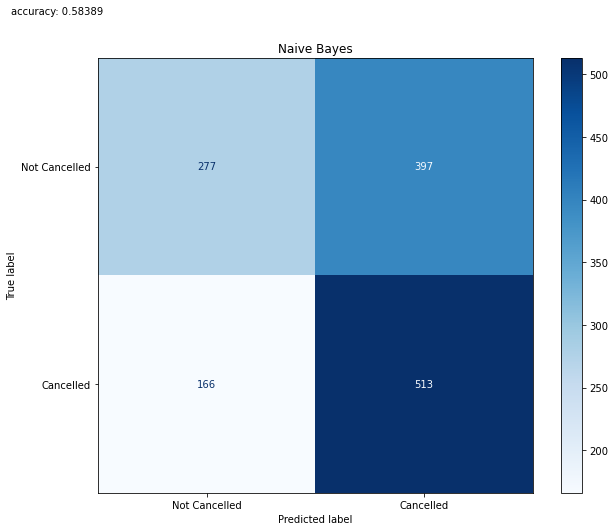

In [29]:
plt.rcParams["figure.figsize"] = (10,8)
disp = plot_confusion_matrix(clf,X_test,y_test,cmap=plt.cm.Blues,display_labels=['Not Cancelled','Cancelled'])
plt.title('Naive Bayes')
plt.text(-.9,-.7,s='accuracy: ' + str(np.round(accuracy_score(y_test,y_pred),5)))
plt.savefig('figs/Bayes_under.png')
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
# param_grid = {
#     'n_estimators': [75,100,150,200],
#     'max_depth': [5,6,None],
# }

# grid = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, n_jobs=-1, verbose = 1)

# grid.fit(X_train,y_train)

In [32]:
#grid.best_params_

In [33]:
clf = RandomForestClassifier(max_depth=None,n_estimators=200)

In [34]:
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200)

In [35]:
y_pred = clf.predict(X_test)

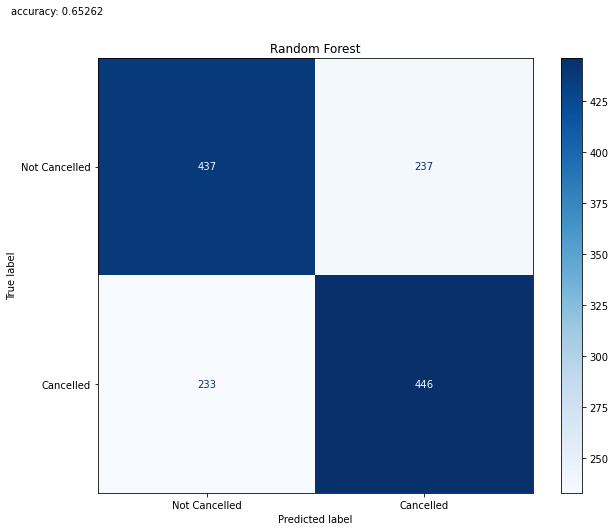

In [36]:
plt.rcParams["figure.figsize"] = (10,8)
disp = plot_confusion_matrix(clf,X_test,y_test,cmap=plt.cm.Blues,display_labels=['Not Cancelled','Cancelled'])
plt.title('Random Forest')
plt.text(-.9,-.7,s='accuracy: ' + str(np.round(accuracy_score(y_test,y_pred),5)))
plt.savefig('figs/Random_Forest_under.png')
plt.show()

In [37]:
from xgboost import XGBClassifier

In [38]:
# param_grid = {
#     'n_estimators': [75,100,150,200],
#     'max_depth': [4,5,None],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# grid = GridSearchCV(estimator = XGBClassifier(), param_grid = param_grid, n_jobs=-1, verbose = 1)

#grid.fit(X_train,y_train)

In [39]:
#grid.best_params_

In [40]:
#clf = XGBClassifier(max_depth=grid.best_params_['max_depth'],n_estimators=grid.best_params_['n_estimators'],learning_rate=grid.best_params_['learning_rate'])
clf = XGBClassifier(max_depth=5,n_estimators=150,learning_rate=0.1)

In [41]:
clf.fit(X_train,y_train)

D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:01:15] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

D:\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


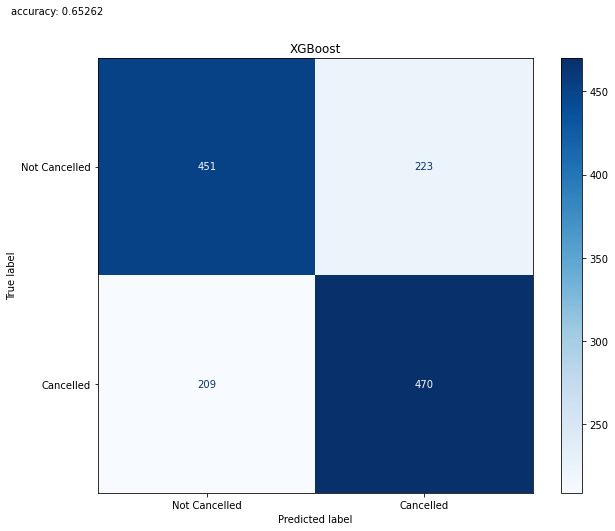

In [42]:
plt.rcParams["figure.figsize"] = (10,8)
disp = plot_confusion_matrix(clf,X_test,y_test,cmap=plt.cm.Blues,display_labels=['Not Cancelled','Cancelled'])
plt.title('XGBoost')
plt.text(-.9,-.7,s='accuracy: ' + str(np.round(accuracy_score(y_test,y_pred),5)))
plt.savefig('figs/XGBoost_under.png')
plt.show()

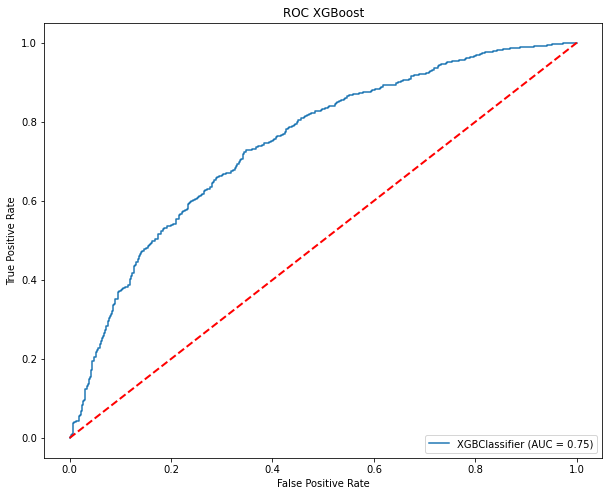

In [43]:
plt.rcParams["figure.figsize"] = (10,8)
disp = plot_roc_curve(clf,X_test,y_test)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.title('ROC XGBoost')
plt.savefig('figs/ROC_XGBoost_under.png')
plt.show()

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**